In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
sns.set_style("white")
# from torchvision import datasets
# from torchvision.transforms import ToTensor

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sample_file = "./differential_expression_zscores.xlsx", metadata_file="metadata.tsv"):
        # Read file containing samples, then index by gene name (so we can say for gene name x, these are the gene expression levels associated with that gene)
        self.data = pd.read_excel(sample_file).fillna(0).set_index("Gene Name").T
        self.shape = (len(self.data.index), len(self.data.iloc[0]))

        # Use metadata to get which samples are healthy and not healthy.
        # Read metadata file, then index by "Sample" (the sample names, ex GSM260895)
        self.metadata = pd.read_csv(open(metadata_file, "r"), delimiter="\t").set_index("Sample")
        self.class_list = self.data.index

    # Return number of samples
    def __len__(self):
        return len(self.data.index)

    def __getitem__(self, idx):
        # Given an index, find the index within self.data, then find the corresponding index name,
        # Look it up in self.metadata, and return the value
        data_sample = self.data.iloc[idx]
        options = ["Healthy", "SLE"]
        categorical = np.zeros(len(options))
        
        categorical[options.index(self.metadata.loc[data_sample.name]["Condition"])] = 1
        return torch.from_numpy(data_sample.to_numpy()).float(), torch.from_numpy(categorical).float()


In [5]:
# Load data (this can take a while)
data = Dataset()
data, data.__getitem__(1), data.shape

(<__main__.Dataset at 0x7f5310164ee0>,
 (tensor([ 0.5511,  0.4965,  0.7744,  ...,  0.5926, -0.8119, -0.1592]),
  tensor([1., 0.])),
 (1023, 4911))

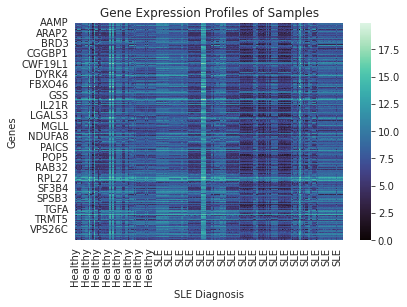

In [20]:
# Sort the data by lupus or no lupus
sorted_data = data.copy()
sorted_data.loc["f"] = metadata.loc[data.columns]["Condition"] #.drop('f', axis=1)
sorted_data = sorted_data.sort_values(by="f", axis=1)

data_rem_names = sorted_data.rename(columns = { col: sorted_data.loc["f"][col] for i, col in enumerate(sorted_data.columns) }).drop("f")
data_rem_names.index.rename("Genes", inplace=True)
data_rem_names = data_rem_names.astype("float32")

plot = sns.heatmap(data_rem_names, cmap="mako")
plot.set(title= "Gene Expression Profiles of Samples", xlabel="SLE Diagnosis")
plot.get_figure().savefig("gene_expression.png")

In [6]:
# Load data into PyTorch
loader = torch.utils.data.DataLoader(data,
                                    batch_size=64,
                                    shuffle=True)

size = loader.dataset.shape
print(size)
train_ds, test_ds = torch.utils.data.random_split(loader.dataset, (size[0] - 100, 100))

(1023, 4911)


In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        # Initialize module
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=data.shape[1], out_features=10, bias=False),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
            # nn.Softmax(dim=0)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4911, out_features=10, bias=False)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d} /{size:>5d}]")

In [12]:
def test(name, dataloader, model, loss_fn, best_correct = None):
    size = 0
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # print((abs(pred[0] - y[0]) + abs(pred[1] - y[1])).sum().item(), pred, y)
            # wrong += (abs(pred[0] - y[0]) + abs(pred[1] - y[1])).sum().item() / 2.0
            correct += (pred.argmax() == y.argmax()).sum().item()
            size += 1
    test_loss /= num_batches
    if best_correct is not None:
        if correct / size > best_correct:
            print(F"Better accuracy: {correct / size}, saving to disk...")
            torch.save(model.state_dict(), "model_best.pth")
    print(f"{name} Error: \n Accuracy: {((correct / size) * 100):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return max(correct / size, best_correct if best_correct is not None else 0)

In [13]:
epochs = 100
best_correct = 0
model = model.float()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_ds, model, loss_fn, optimizer)
    test("Test", test_ds, model, loss_fn)
    best_correct = test("Train", train_ds, model, loss_fn, best_correct)
print("Done!")

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Epoch 1
-------------------------------
loss: 0.000117  [    0 / 1023]
loss: 0.011022  [  100 / 1023]
loss: 0.004884  [  200 / 1023]
loss: 0.001285  [  300 / 1023]
loss: 0.439273  [  400 / 1023]
loss: 0.025079  [  500 / 1023]
loss: 0.350079  [  600 / 1023]
loss: 0.510049  [  700 / 1023]
loss: 0.456909  [  800 / 1023]
loss: 0.000907  [  900 / 1023]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.360350 

Better accuracy: 0.8255687973997833, saving to disk...
Train Error: 
 Accuracy: 82.6%, Avg loss: 0.352626 

Epoch 2
-------------------------------
loss: 0.000188  [    0 / 1023]
loss: 0.000491  [  100 / 1023]
loss: 0.000210  [  200 / 1023]
loss: 0.001583  [  300 / 1023]
loss: 0.197789  [  400 / 1023]
loss: 0.002630  [  500 / 1023]
loss: 0.373627  [  600 / 1023]
loss: 0.159983  [  700 / 1023]
loss: 0.213361  [  800 / 1023]
loss: 0.000078  [  900 / 1023]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.674903 

Better accuracy: 0.8342361863488624, saving to disk...
Train Error: 
 Accuracy: 83.4%, A

In [14]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [37]:
model.eval()

with torch.no_grad():
    # Go through each thing and make it super big, then super small, then detect its impact on our predictions
    size = data.shape[1]
    input_val = np.zeros([size, size])
    for pos, _ in enumerate(input_val):
        input_val[pos][pos] = 3
    inp_t = torch.from_numpy(input_val).float()
    pred = nn.Softmax(dim=1)(model(inp_t)).numpy()
    
    # Now find the largest predictions
    genes = data.data.index
    new_arr = np.zeros([size, 2])
    new_arr[:,0] = pred[:,1]

    for pos, _ in enumerate(input_val):
        input_val[pos][pos] = -3
    inp_t = torch.from_numpy(input_val).float()
    pred = nn.Softmax(dim=1)(model(inp_t)).numpy()
    
    new_arr[:,1] = pred[:,1]

In [63]:
pd_ds = pd.DataFrame(new_arr, index=data.data.columns, columns=["Upregulated", "Downregulated"])

# Go through, sort, and create new column
pd_ds["Max"] = pd_ds[["Upregulated", "Downregulated"]].max(axis=1)

vals = pd_ds.sort_values(by=["Max"], ascending=False)
vals.to_csv("interesting.csv")

In [70]:
pd.options.display.max_rows = 1000
pd.options.display.max_seq_items = 1000

from IPython.display import HTML
HTML(vals[:100].to_html())

,Upregulated,Downregulated,Max
Gene Name,,,
USP18,0.807227,0.234586,0.807227
XIST,0.803813,0.049959,0.803813
ALMS1,0.209829,0.798347,0.798347
AVIL,0.215426,0.793529,0.793529
AUTS2,0.203965,0.788753,0.788753
ISG15,0.782489,0.313925,0.782489
HERC5,0.781336,0.358409,0.781336
TUBA1A,0.425195,0.777822,0.777822
IFITM3,0.769035,0.304145,0.769035


In [85]:
# Now save everything > 60% into a lil folder
downreg_list = []
upreg_list = []
for i in vals.index:
    loc_pos = vals.loc[i]
    if loc_pos["Max"] > 0.65:
        # Save into either down or upregulated list
        if loc_pos["Upregulated"] > loc_pos["Downregulated"]:
            upreg_list.append(i)
        else:
            downreg_list.append(i)

In [88]:
# Save to disk
u = open("upregulated_list.csv", "w")
u.write("\n".join(upreg_list))
u.close()

d = open("downregulated_list.csv", "w")
d.write("\n".join(downreg_list))
d.close()